In [1]:
from loveisland.pipeline.get_topics import GetTopics
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import os

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pyLDAvis.sklearn
import datetime as dt 

from loveisland.common.functions import Functions as F

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use("bmh")

In [2]:
ISLANDERS = {
    k: v
    for k, v in F.get_islanders_s().items()
    if v["season"] == 5
    and v["arrived"] <= 36
    and (v["dumped"] >= 36 and v["dumped"] <= 50 or v["dumped"] == 0)
}

In [3]:
class Arguments():
    bucket = "../data/"
    season = 5
    
args = Arguments()

For the third part of my series on Love Island we shall focus on creating topic models for the episodes aired on the 4th and 5th weeks of season 5. I would like to dive further into the themes and common topics being tweeted about, determining if a machine can pull out the key talking points of each episode. 

### What are Topic Models / LDA?
Topic models are machine learning models/algorithms that aim to group similar documents in a corpus and extract key themes ('topics') across similar documents. Often topic models are used as part of a text mining pipeline to find patterns within text and as a way to process a large number of documents without having to manual read them. 

We are going to use a Latent Dirichlet Allocation (LDA) model for this work, LDA models are relatively simple; 
1. The algorithm assigns every unique word in the whole corpus randomly to a topic (the user tells the model how many topics when building the model)
2. A probability of each document being in each topic can be calculated via p(topic | document)
3. We can then calculate the 'importance' of each work per topic (for example, if a word is in a document, how likely is it that that document is in a topic) using the formula p(word | topic)
4. We are left with a series of Dirichlet distributions, from these we can reassign words a new topic that will lead to a more optimum model. 

Iterating over step 4 a large number of times leads to 'the best' model and can be used to determine the likelihood of each document being in each topic. LDA models do not manually label topics so there is some human intervention needed however given the way they are often implemented this is usually very easy. For this piece I will be using the `LatentDirichletAllocation` class in the `scikit-learn` package.

In [4]:
class DateRange:
    def __init__(self, d0="2019-06-24", d1="2019-07-08"):
        self.d0 = self.fmt_dt(d0)
        self.d1 = self.fmt_dt(d1)
        
        self.dates = self.get_dates()

    @staticmethod
    def fmt_dt(d):
        return dt.datetime.strptime(d, "%Y-%m-%d")

    def get_dates(self):
        delta = self.d1 - self.d0
        return [
            str((self.d0 + dt.timedelta(days=i)).date()) for i in range(delta.days + 1)
        ]

In [5]:
dr = DateRange()

In [6]:
EVENTS = {
    " Third Recoupling \n Yewande Dumped": {"date": "2019-06-24", "color": "Red", "h": 1, "t": 10, "d": 22},
    " Arabella and Tom \n are Dumped": {"date": "2019-06-27", "color": "Red", "h": 1, "t": 3, "d": 25},
    " Casa Amor Begins": {"date": "2019-06-28", "color": "Green", "h": 2, "t": 3, "d": 26},
    " Fourth Recoupling \n Dan, Dennon, Stevie \n Lavena, Maria and Nabila dumped": 
    {"date": "2019-07-02", "color": "Green", "h": 2, "t": 10, "d": 30},
    " Danny,\n Jourdan,\n Lucie\n and\n George\n dumped": 
    {"date": "2019-07-08", "color": "Red", "h": 1, "t": 3, "d": 36},
}
for_tl = pd.DataFrame({"date": dr.dates, "filler": 1})

### Timeline of Events
We will primarily be focusing on episodes aired in weeks 4 and 5 of Love Island, in this time period we watch 2 re-couplings (a time which saw a lot of activity in the [second piece](https://medium.com/@watson.sam/100-my-type-on-paper-watching-love-island-via-data-analytics-part-2-fb76dbc87070) in this series), as well as containing the 5 episodes of 'Casa Amor' and the reaction to all of the drama brought about by this. Whilst the below chart seems relatively empty compared to the last part, be assured that lots happened; we saw Michael's head 'get turned' by new girl Joanna with him leaving Amber for her (with them going into Casa Amor as one of the strongest couples), Curtis realising he doesn't like Amy (arguably the bookies favourite couple to win the show), Anna coupling up with Ovie, returning to the main villa to a single Jordan and then Jordan 'winning her back', amongst other goings on!  

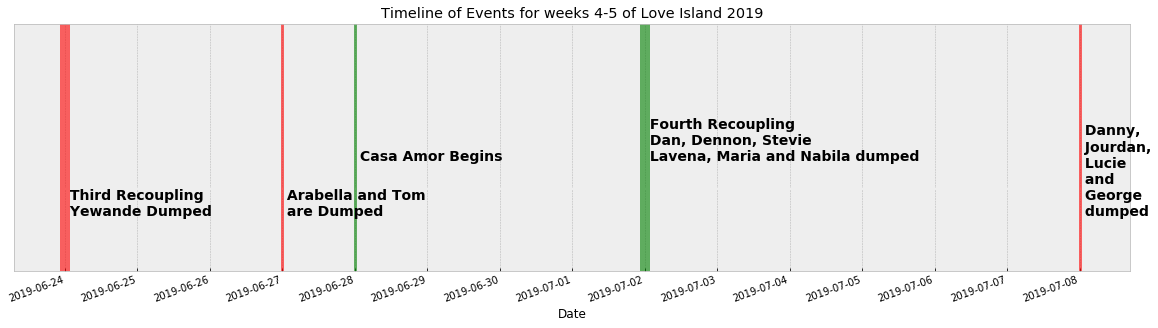

In [7]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(211)

sns.lineplot(x="date", y="filler", color="#EEEEEE", data=for_tl, ax=ax1)
plt.xticks(rotation=20, ha="right")
ax1.set(xticks=for_tl.date.unique(), yticks=[], xlabel="Date", ylabel="", ylim=(0, 3), 
       title="Timeline of Events for weeks 4-5 of Love Island 2019")

for key, item in EVENTS.items():
    ax1.axvline(item["date"], color=item["color"], linewidth=item["t"], alpha=0.6)
    ax1.text(item["date"], 2 * item["h"] / 3, key, fontsize=14, weight="bold")


In [8]:
class GetInputs:
    def __init__(self, args, dates):
        self.args = args
        self.dates = dates
        self.stored = {}
        self.to_plot = None

    def import_aspects(self, dt):
        """Import model + vocabulary for a given date"""
        path = os.path.join(
            self.args.bucket, "season_" + str(self.args.season), "{}", str(dt) + ".pkl"
        )
        return (
            pickle.load(open(path.format("models"), "rb")),
            pickle.load(open(path.format("vocab"), "rb")),
        )

    def setup_aspects(self, dt, col="processed_text"):
        """Set up all the aspects from the topic modelling we need downstream"""
        gt = GetTopics(self.args, dt)
        gt.import_data()

        mod, vocab = self.import_aspects(dt)

        vectorizer = CountVectorizer(vocabulary=vocab)
        vectorizer._validate_vocabulary()
        A = vectorizer.fit_transform(gt.df[col])
        return gt.df, mod, vectorizer, A, vectorizer.get_feature_names()

    @staticmethod
    def topic_probs(doc_tops, df):
        """Assign the 'most likely' topic for every tweet in the corpus and the probability
        of that tweet being in that topic compared with any others"""
        for_df = []
        for i in range(len(doc_tops)):
            js = {str(j): float(doc_tops[i][j]) for j in range(len(doc_tops[i]))}
            js["processed_text"] = df["processed_text"][i]
            for_df.append(js)

        for_df = pd.melt(
            pd.DataFrame(for_df), id_vars=["processed_text"], var_name="topic"
        )
        for_df["val_max"] = for_df.groupby(["processed_text"])["value"].transform(max)
        for_df = (
            for_df[for_df["value"] == for_df["val_max"]]
            .drop(columns="val_max")
            .reset_index(drop=True)
        )
        df = df.merge(for_df, on="processed_text", how="left").drop_duplicates(
            ["processed_text"]
        )
        df["text"] = df["text"].astype(str)
        return df[~df["text"].str.contains("pic.twitter.com")].reset_index(drop=True)

    def fill(self, dt, df, mod, vectorizer, A, bag_of_words):
        """Fill a dictionary with all the gathered elements for a given date"""
        self.stored[dt] = {
            "df": df,
            "mod": mod,
            "vectorizer": vectorizer,
            "A": A,
            "bag_of_words": bag_of_words,
            "n_tweets": df.url.nunique(),
            "perplexity": mod.perplexity(A),
        }
        return self

    def wrapper(self, dt):
        """Bring all methods together for a given date"""
        df, mod, vectorizer, A, bag_of_words = self.setup_aspects(dt)
        doc_tops = mod.transform(A)
        df = self.topic_probs(doc_tops, df)

        self.fill(dt, df, mod, vectorizer, A, bag_of_words)
        return self

    def get_all(self):
        """Loop over all dates we want to include in analysis"""
        for dt in self.dates:
            self.wrapper(dt)
        return self

    @staticmethod
    def dict_to_df(_dict, col="date"):
        """Transform a dictionary to pandas df"""
        df = pd.DataFrame.from_dict(_dict, orient="index")
        df.index.name = col
        return df.reset_index(drop=False)

    def prep_for_plot(self):
        """Extract relevant columns for a plot"""
        self.to_plot = {
            k: {"n_tweets": v["n_tweets"], "perplexity": v["perplexity"]}
            for k, v in self.stored.items()
        }
        self.to_plot = self.dict_to_df(self.to_plot)
        return self

    def add_params(self):
        """Augment df with parameters used in the topic modelling"""
        params = pickle.load(
            open(
                os.path.join(
                    args.bucket, "season_" + str(args.season), "best_param.pkl"
                ),
                "rb",
            )
        )
        params = self.dict_to_df(params)
        self.to_plot = self.to_plot.merge(params, on="date", how="left")
        self.to_plot["date"] = self.to_plot["date"].astype(str)
        return self


In [9]:
gi = GetInputs(args, dr.dates)
gi.get_all().prep_for_plot().add_params()

### Method / Implementation
I am going to use exactly the same preprocessing pipeline as per part two of this series, this proved successful initially and is very aggressive at reducing noise in the tweet data which is a lot more important for topic modelling than for sentiment analysis. To try and make sure we are getting the optimum parameters when building each model I am going to use a `GridSearch` (again from the `scikit-learn` package), this allows us to iterate over a number of parameters and returns a model that is best for our data; for each day I am going to run a grid search of number of topics = [10, 15, 20, 25, 30] and learning decays = [0.3, 0.5, 0.7, 0.9]. In LDA models, the learning decay is the rate at which old information / weights are forgotten per iteration, ie how much weight does a topic hold after it has been created in relation to a potential new topic, therefore a low learning decay means that topics will change a lot more and the model will take a lot longer to converge on the optimum topics. To evaluate each model in the grid search we shall use 'Model Perplexity', this is a quantitative approach that is the average log-likelihood of a test set of documents from the original corpus (ie documents not used for the training), whilst ideally this step would be done via human interaction, it would be way too time consuming and slightly defeats the point! Whilst it could be argued that to evaluate text based model one has to have some knowledge about the context of the words etc, it has [been proved](https://mimno.infosci.cornell.edu/papers/wallach09evaluation.pdf) that model perplexity is a very good method to use. 

### Preliminary Evaluation
After doing a grid search per day and extracting the optimum model for every corpus of tweets, we can plot the perplexity for each model as well as the parameters used; in every case 10 was the optimum number of topics. I would also like to investigate the relationship between the number of documents per day and the optimum learning decay therefore on the same plot we can overlay this count. 

One could argue that there is a negative correlation between the number of tweets contained in the corpus and the learning decay (ie the greater the total tweets, the lower the learning decay). This is neither a hugely significant relationship or surprising as one would expect a larger range of topics in a larger corpus, therefore a smaller learning decay needed as the model will need to iterate more to make sure no 'local minima' are missed and more time to evaluate that the topics are indeed optimum. Given the multi-faceted nature of Love Island with the amount of both individual and couple based storylines that are often interlinked per episode with each being likely to result in a significant number of tweets, it is expected that the models will take longer to reach their conclusion. 

On the day we saw the most tweets (7th July; the re-coupling / ending of Casa Amor), there were 3 of the biggest stories of the show coming to a point (both Anna and Michael re-coupling with new islanders and leaving their original partner single as well as the controversy / drama surrounding Amy and Curtis' relationship), given this one would imagine that the model needed to be more dynamic in changing the weighing of topics and therefore required a lower learning decay. In comparison, we see that on Saturdays (the days where no show is aired and therefore receives the least tweets), the models performed the best (based on perplexity) with large learning decays.  

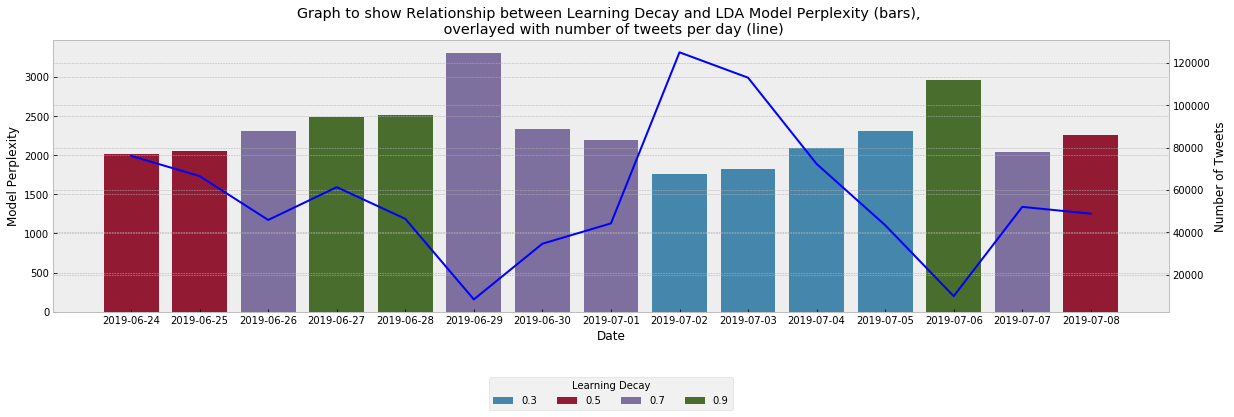

In [10]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

sns.barplot(
    "date", "perplexity", "learning_decay", data=gi.to_plot, dodge=False, ax=ax1
)
ax1.set(
    xlabel="Date",
    ylabel="Model Perplexity",
    title="Graph to show Relationship between Learning Decay and LDA Model Perplexity (bars), \n "
    "overlayed with number of tweets per day (line)",
)

sns.lineplot(x="date", y="n_tweets", color="Blue", data=gi.to_plot, ax=ax2)
ax2.set_ylabel("Number of Tweets")

plt.xticks(rotation=20, ha="right")
ax1.legend(loc="center", bbox_to_anchor=(0.5, -0.3), ncol=5, title="Learning Decay");

In [11]:
class TopicModFunctions:
    def __init__(self, stored):
        self.stored = stored
        self.pholder = None

    def get_elements(self, dt):
        """Extract"""
        self.pholder = self.stored[dt]
        return self

    def get_terms(self, dt, n_words=10, print_terms=False):
        self.get_elements(dt)

        for_df = []
        for topic_idx, topic in enumerate(self.pholder["mod"].components_):
            terms = [
                self.pholder["bag_of_words"][i]
                for i in topic.argsort()[: -(n_words + 1) : -1]
            ]
            for_df.append({"topic": topic_idx, "terms": terms})
            if print_terms:
                print("Topic", topic_idx, ":", terms)
        return pd.DataFrame(for_df)

    def top_doc(self, dt, sb_col):
        self.get_elements(dt)

        df = (
            self.pholder["df"][self.pholder["df"]["value"] > 0.6]
            .sort_values(by=sb_col, ascending=False)
            .groupby(["topic"])
            .head(1)
            .sort_values(by="topic")
            .reset_index(drop=True)
        )

        print("Top document per topic")

        for i, row in df.iterrows():
            print(
                "Topic {0} (probability={1})".format(
                    row["topic"], round(row["value"], 2)
                ),
                "\nText:",
                row["text"],
                "\n",
            )
            
    def topic_senti(self, dt):
        self.get_elements(dt)
        df = self.pholder["df"]
        
        means = df.groupby("topic")["score"].mean().reset_index(name="topic_mean_senti")
        means['colour'] = np.where(means["topic_mean_senti"] >= 0, "Positive", "Negative")
        return df.merge(means, on="topic", how="left")
    
    def islander_dist(self, dt):
        self.get_elements(dt)
        df = self.pholder["df"][self.pholder["df"]["value"] > 0.5]

        full = pd.DataFrame()
        for islander in ISLANDERS:
            temp = df[df[islander] == islander].groupby("topic")["url"].count().reset_index(name="n")
            temp["islander"] = islander

            if temp.n.sum() > 1000:
                full = full.append(temp, sort=True)
        return full

In [12]:
tmf = TopicModFunctions(gi.stored)

### Insight
Whilst I would ideally like to focus on multiple days and models, this isn't really feasible in one piece of work, therefore we shall proceed with just the topic model from 7th July; this is the day with the most tweets and statistically the worst model, therefore will be the biggest test of how appropriate the LDA model is for this work.

As discussed above, each document (tweet in our case) has a probability assigned to it being in each topic, ie every tweet has a set of probabilities that sum to 1, we want to associate each tweet with the topic it is most likely to be grouped with. Once we have one topic per tweet we can plot the number of distinct tweets per topic, I have also overlaid the top 10 most relevant words to each topic so we can start to get a picture of the main themes.

Topic 5 contains the greatest number of tweets (over 20,000), given the key words it is clear that this centers around tweets referencing the fact that Michael coupled up with a different girl (Joanna) leaving Amber single (based on the key words it appears that a vast number of twitter users are calling Michael a 'fuck boy', also a very high number are spelling his name wrong). In topic 6 we see Amber and Michael as keywords again, whilst this may initially be confusing, we need to remind ourselves of the steps taken to fit the model and that the keywords to each topic may not be assigned to that topic themselves, they just frequently appear in documents that make up the topic alongside the words that are assigned to the topic. In this instance when Michael and Amber are mentioned with Joanna (and the other keywords) the tweeter is speaking about topic 5 however when used in tweets with Ovie and Anna etc then it is topic 6, given what we know about the reactions to this episode (both the reaction to Michael's decision and users calling Anna a hypocrite for reacting the way she did given her own actions) this is very encouraging and a good initial validation of a good model fit. Other topics centre around Molly-Mae's reaction to her and Tommy's emotional re-coupling and also a number picking out different reactions to Curtis' actions, specifically topic 0 which is about Maura's face when Curtis is giving his speech, topics 3 and 8 where twitter users are feeling sorry for Amy and topic 1 where users are anticipating the drama caused by the re-coupling and looking forward to watching the preceding episodes. The distribution of tweets per each topic is not evenly distributed (which you wouldn't expect given some talking points will be focused on a lot more than others), however every topic does receive a large number of tweets (smallest contains just under 5000) which is good for further analysis.

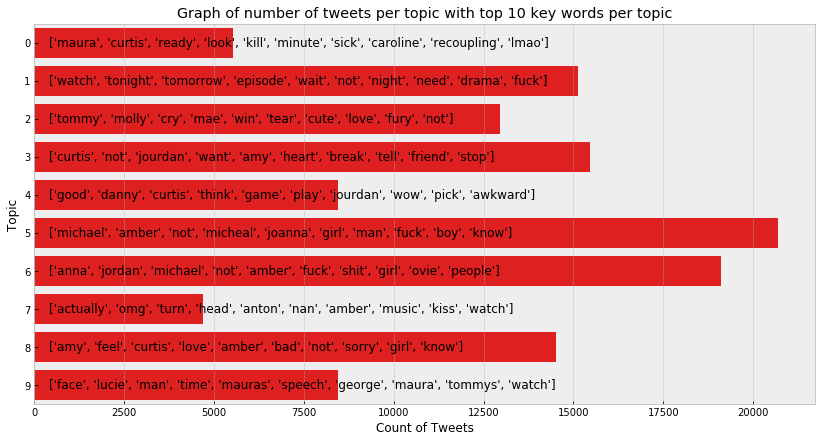

In [13]:
terms = tmf.get_terms("2019-07-02")

df = tmf.pholder["df"].groupby("topic")["value"].count().reset_index(name="count")
df["topic"] = df["topic"].astype(int)

fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(111)

sns.barplot(x="count", y="topic", data=df, color="Red", ax=ax1, orient="h")

for i, row in terms.iterrows():
    ax1.annotate(
        row["terms"],
        xy=(0, 0),
        xytext=(df["count"].max() / 50, i + 0.1),
        color="Black",
        fontsize=12,
    )

ax1.set(
    xlabel="Count of Tweets",
    ylabel="Topic",
    title="Graph of number of tweets per topic with top 10 key words per topic",
);

For a further insight into what the topics "look like" in practice we can pull out the tweet per topic that the model assigns the greatest probability of being in each topic too, statistically this should give us the tweet with the best fit.

In [14]:
tmf.top_doc("2019-07-02", "value")

Top document per topic
Topic 0 (probability=0.96) 
Text: Worden deelnemers betaald en wie kookt er eigenlijk? Achter de schermen van ‘Love Island’ http://www.nieuwsoverzicht.info/2019/07/worden-deelnemers-betaald-en-wie-kookt-er-eigenlijk-achter-de-schermen-van-love-island/ … 

Topic 1 (probability=0.97) 
Text: ah eles não são eliminados? pensava que era kkkkkkk ah agora me animei hehehe eu acho que o dos EUA vai ser legalZINHO e só. Pq pelo que li não vai ser hot e apimentado igual o original, vão censurar muita coisa pelo horário 

Topic 2 (probability=0.97) 
Text: # Brexit # Trump # Boris # etsy # etsyfinds # HandmadeHour # handmadegifts # artsandcrafts # TuesdayMorning # LoveIsland # uniquegiftshttps://www.etsy.com/Cathygiftsandthings/listing/615628060/letter-to-santa-coasters-plastic-canvas?utm_source=Copy&utm_medium=ListingManager&utm_campaign=Share&utm_term=so.lmsm&share_time=1562082429966&sfns=mo … 

Topic 3 (probability=0.96) 
Text: lord give me the confidence of curtis thinki

As can be seen above, the top tweets per topic don't seem all that relevant, especially considering the keywords per topic that we identified above, in fact most of them aren't even in English! Again we need to consider the fact that 
the probability of a tweet being in each topic is based on the individual words in each tweet and that the probabilities per topic are relative to all other topics. As we can see, when we pick the tweet with the highest probability they seem appear almost random given our knowledge about the the corpus. We know the the algorithm finds the probability on a word by word basis, therefore the more key words per topic a text has the more likely it is to be in that topic. We also know that the probability is based on likelihood of being in each topic in comparison to each of the other topics, so therefore if a tweet has a keyword from topic 0 and no words match any keywords from any other topics, the algorithm places a very high probability of this tweet being in this topic even though the actual association is very small, hence why we get the results observed above. Topic 5 is also a funny one; there are very few distinct words (3 plus a hashtag) and one of these is a keyword to the topic, this means that nearly a 3rd of the total words are very highly correlated with the topic, hence the extreme score, whilst this tweet is actually a fair summary of this topic, it would still be the case if the tweet repeated "Michael's a legend" which would have been the opposite to the topic. 


In light of this, to address the fact that this isn't that useful in the real world, we can filter out tweets with less than a 60% probability of being related with a topic and then pull out the most popular tweets in terms of number of favourites on twitter; we would expect these tweet to be highly relevant to each topic, to receive such a high number of favourites they will almost certainly be about love island and therefore due to the topics all featuring key words related to the show, a tweet about love island with a high chance of being in a topic must include a number of the words exclusively related with that topic. 

In [15]:
tmf.top_doc("2019-07-02", "favs")

Top document per topic
Topic 0 (probability=0.62) 
Text: lmaooooo Ana getting in to the action after struggling to even look at Jordan....come onnnnn bruh # LoveIsland 

Topic 1 (probability=0.63) 
Text: Shoutout to Michael for making some absolutely world class TV for the next few days # loveisland 

Topic 2 (probability=0.66) 
Text: As if Molly-Mae walked through the villa and saw her elephant wasn’t on the bed and thought he had got with someone new when in reality he was holding it the whole time I am an emotional WRECK # loveisland 

Topic 3 (probability=0.89) 
Text: Was Jordan not trying to get to know other girls but failed? Or is it not the same Love Island we were watching? # loveisland https://twitter.com/jackblenkiron/status/1146166029032329217 … 

Topic 4 (probability=0.6) 
Text: Imagine having your phone with you when you are next to Danny, always full signal mans got so much connection with everything one and everything # loveisland 

Topic 5 (probability=0.65) 
Text: Amb

As we can see, finding the top tweets per topic this way filters a lot of the noise and we are left with tweets that are all relevant to Love Island, based on the keywords we found above the tweets also give a very good brief insight into each topic. Focusing on topic 1 we see the user looking forward to the upcoming shows, as we thought would be the case when looking at the key words, also topic 2 is about the author being emotional about the Tommy and Molly-Mae reunion as we thought looking at the keywords.

We have seen that there are a large number of tweets per each topic, to try gain an understanding of how good the fit is of the clustering of tweets per topic, we can plot the distributions of the probability of each tweet per assigned topic.  

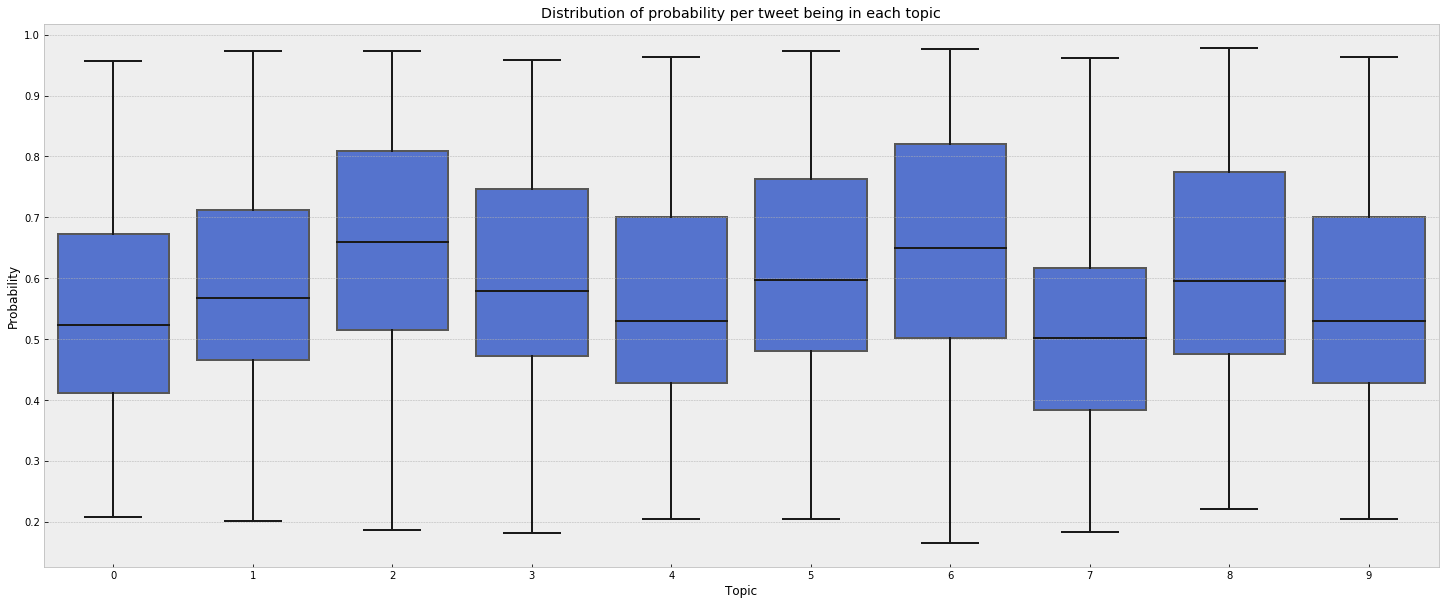

In [16]:
tmf.get_elements("2019-07-02")

fig = plt.figure(figsize=(25, 10))
ax1 = fig.add_subplot(111)

sns.boxplot(x="topic", y="value", data=tmf.pholder["df"], color="royalblue", ax=ax1)
plt.setp(ax1.lines, color=".1")
ax1.set(xlabel="Topic", ylabel="Probability", title="Distribution of probability per tweet being in each topic");

The above box-plots are encouraging; we see the mean for every topic is above 0.5 and the lower quartile above 0.4 in all bar 1 case (topic 7), there are very few values below 0.2. Whilst we have seen that the probability of a tweet being in a particular document not necessarily being that helpful, we see that only in two cases (topics 2 and 6) is the upper quartile above 0.8, this shows that the vast majority of tweets don't have extreme probabilities and suggest that the model can't fit them perfectly as they might be in more than one topic, this means that the tweets are probably above Love Island.

We can also look at the distribution of topics per islander, by this I mean count the number of tweets that contain an islanders name per each topic. Prior to plotting will filter out tweets with less than a probability of less than 0.5 of being associated with the relevant topic, as well as removing islanders who have less than 1000 tweets explicitly referencing them. We again see a good fit on the topics as islanders who share storylines have peaks across the same topics, for example, Curtis, Amy and Jourdan with topic 3 and Tommy and Molly-Mae with topic 2. It is also interesting to see when as islander has multiple peaks, such as Amber and Michael with topics 4 and 5 and that the algorithm has managed recognise that whilst these tweets are similar they have been clustered separately, this is perhaps more intuitive that if a human had sorted the tweets and might not have been able to make the same distinctions, yet when presented with the keywords this split makes a lot of sense.

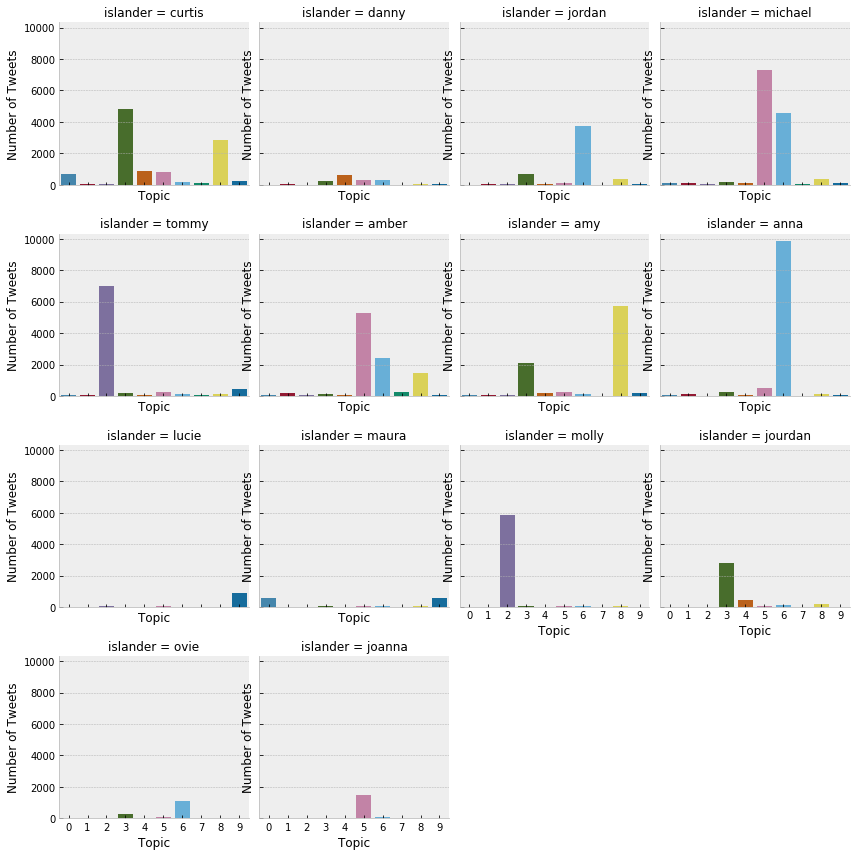

In [17]:
df = tmf.islander_dist("2019-07-02")

order = df.topic.unique()
g = sns.FacetGrid(col="islander", col_wrap=4, data=df, hue="topic")
g.map(sns.barplot, "topic", "n", dodge=True, order=order)

for ax in g.axes:
    ax.set(xlabel="Topic", ylabel="Number of Tweets")
    
plt.subplots_adjust(hspace=0.3)

Whilst the model is categorising tweets mentioning Amber and Michael as different topics, when we look at the 'intertopic distance' we see that the relative similarity of the themes is recognised. We see the topic that contains tweets regarding Molly-Mae and Tommy's reuniting out on their own, potentially due to the fact that it is the only one focusing on positive events and contains reactions of happiness and showing support for the islanders actions rather than criticising.

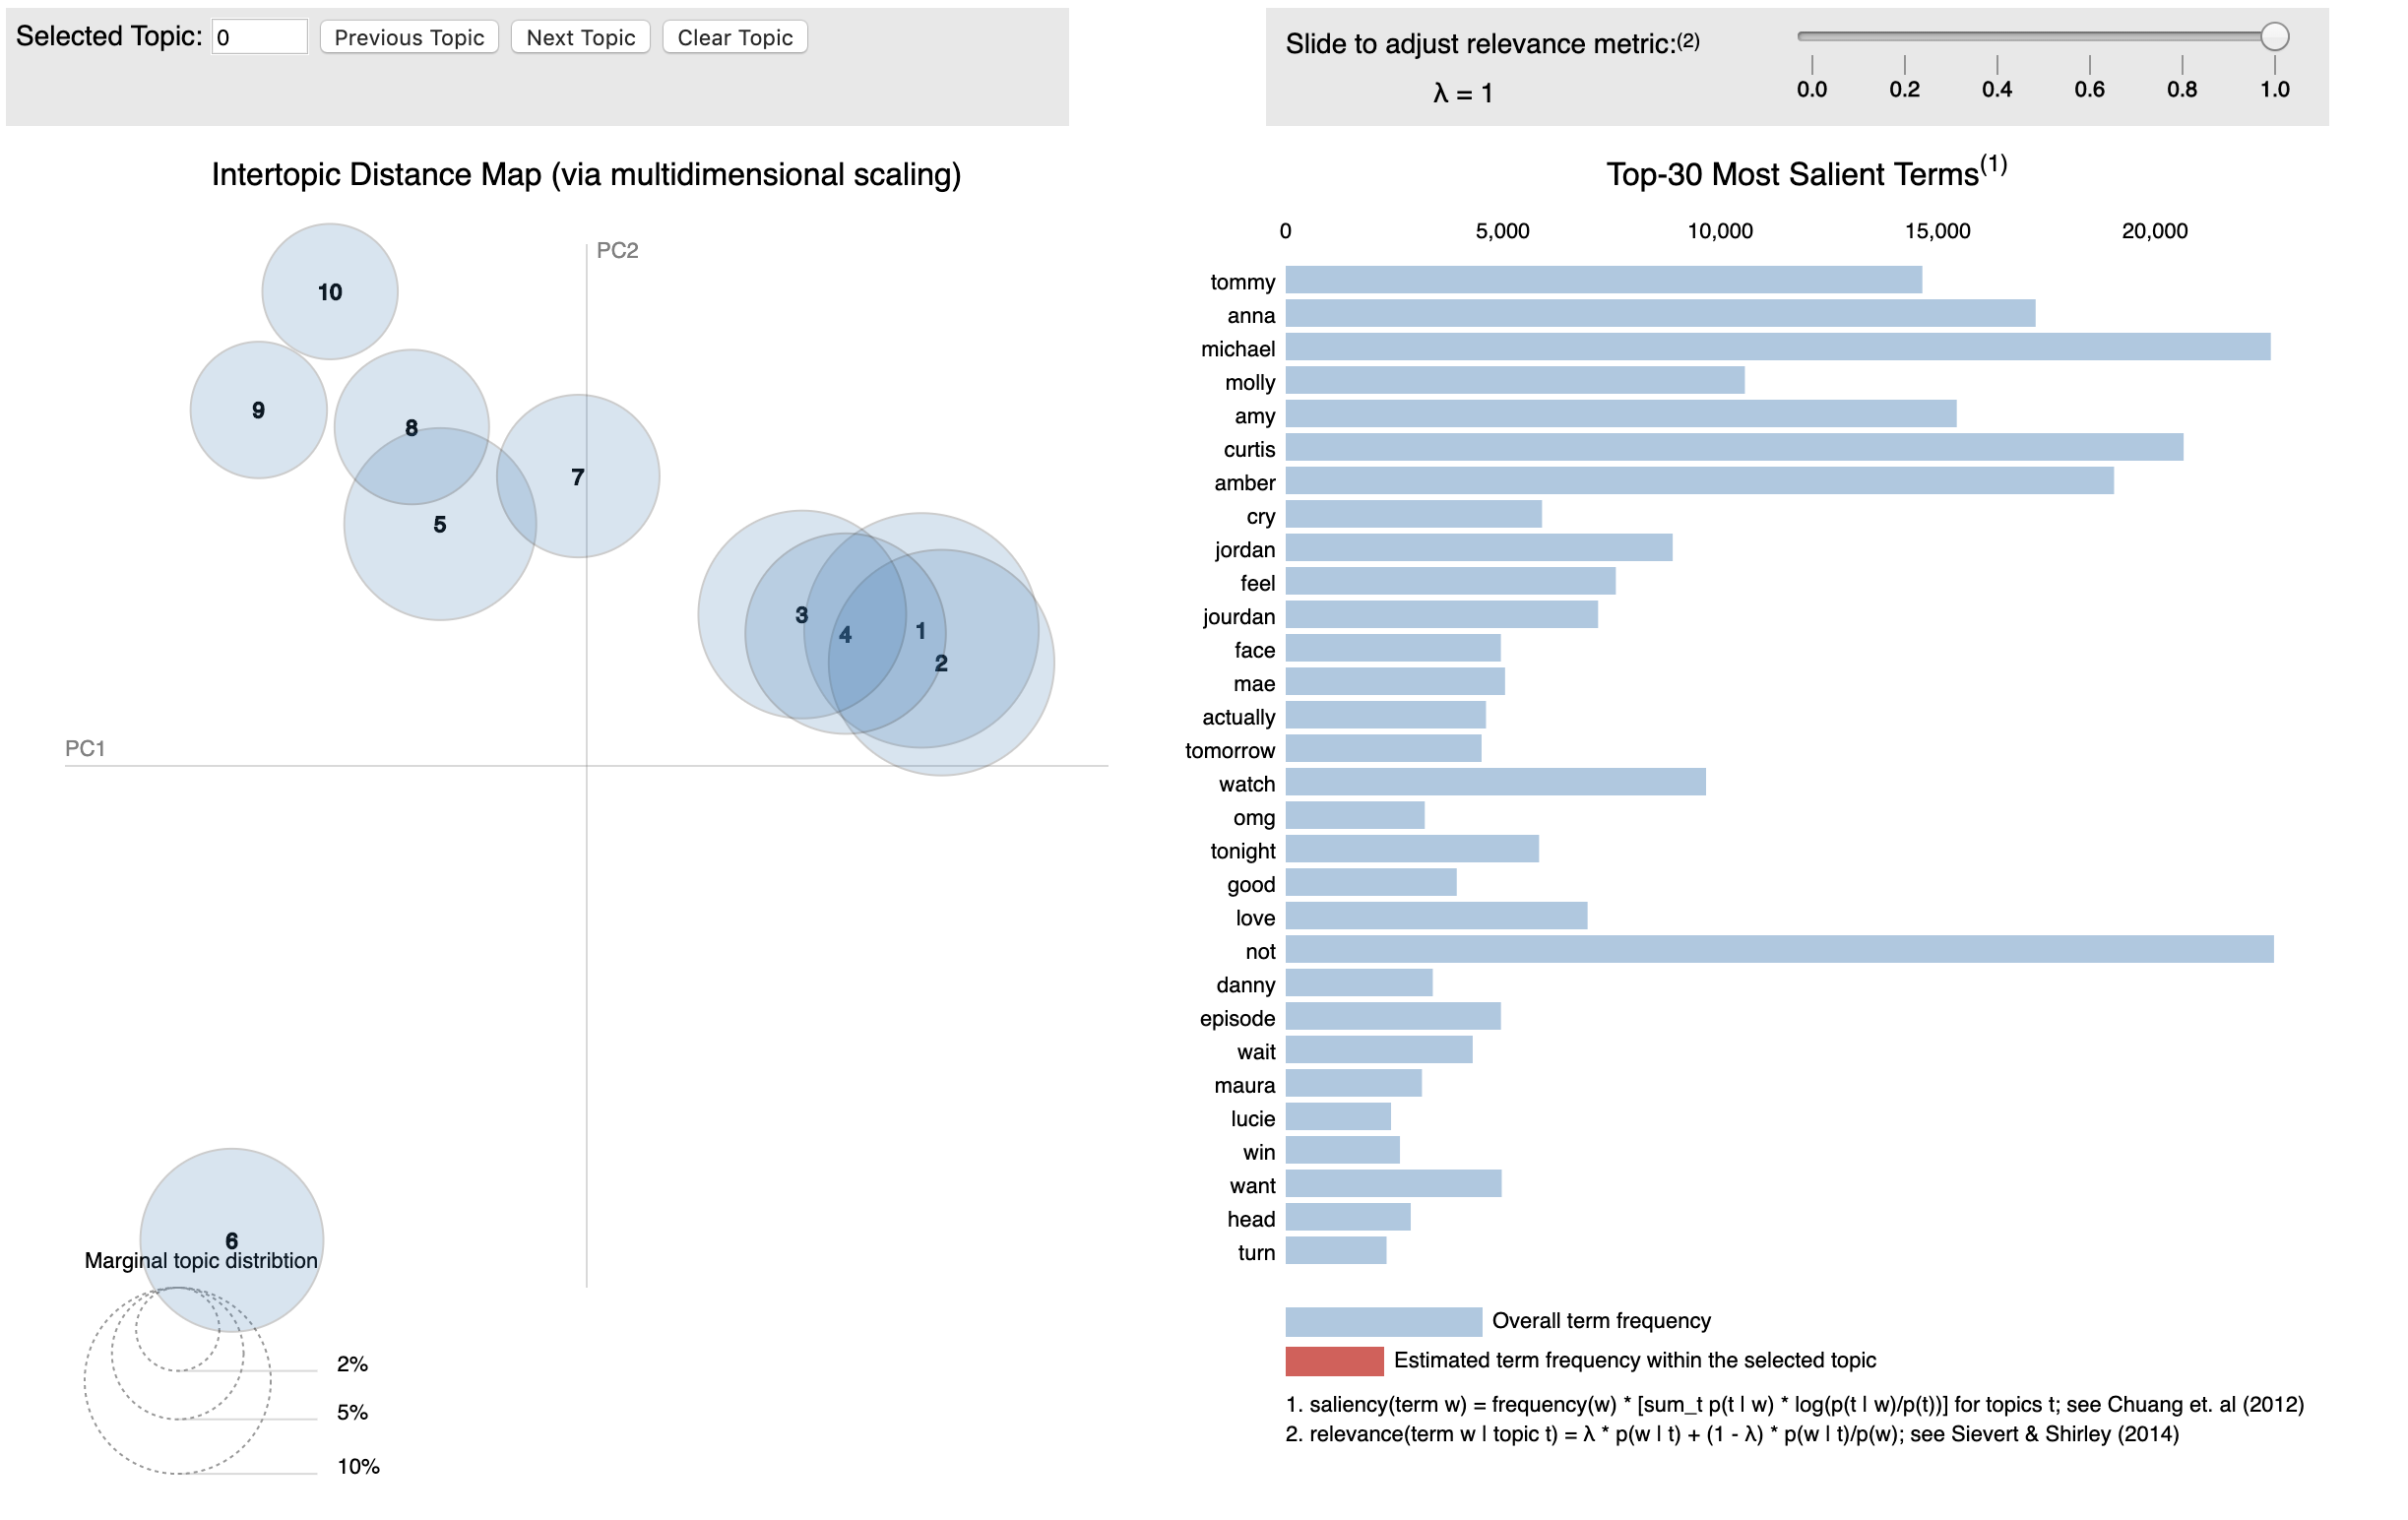

Finally we shall investigate the sentiment behind each topic; plotting the distribution per topic and colouring for if the mean if greater or less than 0 gives us the following chart. As mentioned above, topic 2 (that of Molly-Maes reaction) contains on average the most positive tweets, topics 5 and 6 are the most negative which given the number of references each islander contains suggests that twitter users are not taking kindly to the actions of Michael and Anna. Of the 10 topics, 40% have a mean value over over 0 and are therefore "positive" according to the sentiment analyser, this is slightly surprising in my eyes as I would have assumed that only one topic would have been seen as positive, it is still evidence to suggest that users are much more likely to tweet in reaction to negative actions rather than positive ones. 

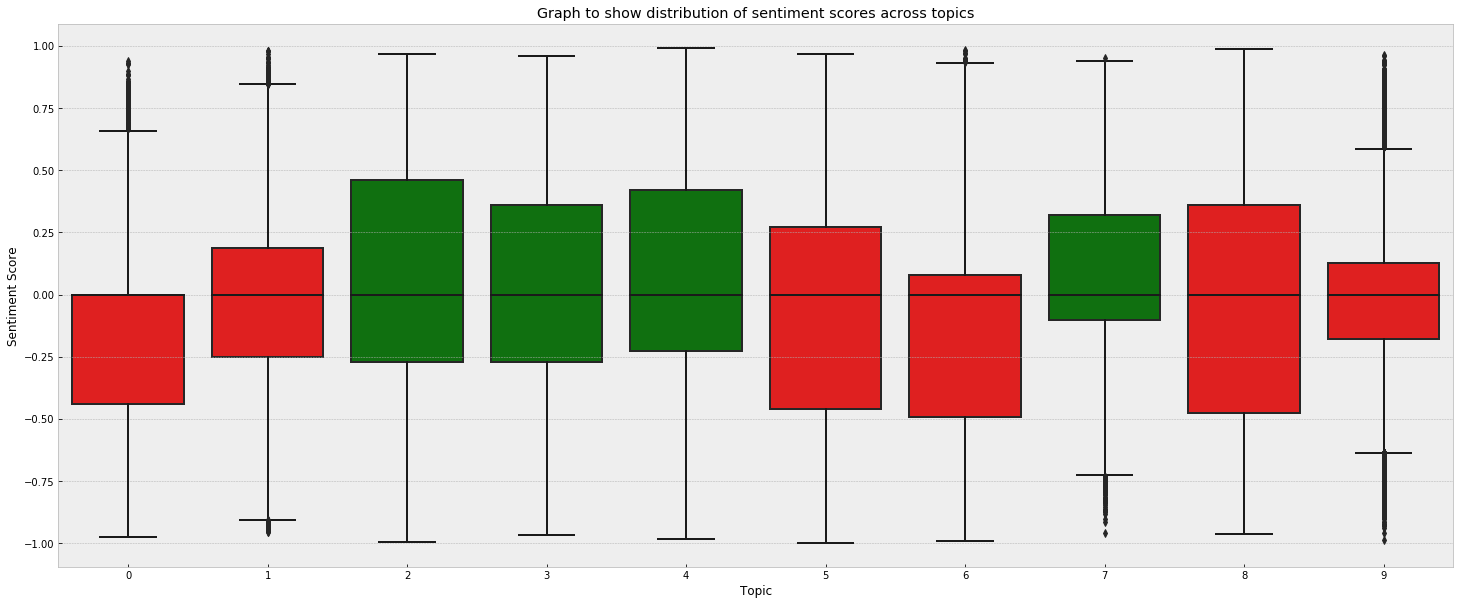

In [18]:
df = tmf.topic_senti("2019-07-02")

fig = plt.figure(figsize=(25, 10))
ax1 = fig.add_subplot(111)

sns.boxplot(
    "topic",
    "score",
    "colour",
    data=df,
    ax=ax1,
    dodge=False,
    palette={"Negative": "Red", "Positive": "Green"},
)
plt.setp(ax1.lines, color=".1")
plt.legend().remove()
ax1.set(xlabel="Topic", ylabel="Sentiment Score", 
        title="Graph to show distribution of sentiment scores across topics");

### Conclusion
To conclude, the output from the LDA topic model we produced for tweets posted about Love Island on 2nd July aligned very well with what we saw on the screen, given that the initial fit statistics suggested that this model was the "worst" out of all the episodes for the 4th and 5th weeks the show was on this is very encouraging. The topic model was able to pull out the key themes and cluster the tweets appropriately, even when the nuance between the exact wording of tweets was small, the algorithm was still able to pull out very distinct topics about the same islanders. At the end of the day, whilst presented as a reality TV show, Love Island is fundamentally a game show where the contestants are playing to win a cash prize, future islanders could use topic models to analyse very efficiently which behaviours / actions go down the best with the public (or at least the users on twitter) to give themselves as better chance of winning. Topic models would also be a good method for the producers of the show to use to work out what aspects of the show viewers enjoy and could be used to guide decision making for future challenges / interventions that the producers make when creating the show. Whilst I do think that topic models could be used for good, likewise they could also be used to determine the aspects of the show that gained the most reaction online and got the most people talking with these to be promoted in future episodes, as we have seen this is often negative behaviours and generally actions from individuals that are at the expense of another contestant (the Michael re-coupling reactions that we have seen above for example).